Trains a grammar encoder to predict meta-scene-tree production params (grammars) on the 2D box grammar.

In [ ]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks_complex.grammar import *

Unconditional grammar outputs look like this:

In [ ]:
root_inst_dict = {"xy": dist.Normal(torch.tensor([0., 0.]), torch.tensor([0.001, 0.001]))}
grammar = SceneGrammar(Ground, root_inst_dict)
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = grammar()
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

In [ ]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
observed_full_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_full_trees.append(scene_trees[0])
plt.show()

In [ ]:
trace = pyro.poutine.trace(grammar.forward).get_trace()
print(trace.nodes.keys())

The "meta" ("super"? "Hyper", as in hypergraph? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneGrammar.make_super_scene_tree(Ground)
ordering = nx.dfs_postorder_nodes(meta_tree, source=get_tree_root(meta_tree))
index_by_node = {node: k for (k, node) in enumerate(ordering)}
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.

In [ ]:
# Build observed trees
observed_trees = []
for tree in observed_full_trees:
    observed_tree = SceneTree()
    for node in tree:
        if isinstance(node, Box):
            observed_tree.add_node(node)
    observed_trees.append(observed_tree)

plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        k = i*N_height + j
        ax = plt.subplot(N_height, N_width, k + 1)
        draw_boxes(observed_trees[k], fig=fig, ax=ax, block=False)
        ax.axis("on")
plt.show()

## Neural grammar proposal generator on various grammars

Train an encoder to take a set of observed nodes and produce distributions over grammar parameters that are more likely to have generated those specific nodes.

##### Encoder

Exceedingly simple encoder: GRU iterations over (randomly reordered) fixed-size embeddings of each observed node, where the input is a fixed-size embedding and hidden state is the parameters of the distribution over parameters . Embeddings are generated by per-observed-node-type networks to transform variable-size node parameters into a fixed size parameter vector. 

#### Decoder and observation likelihood

A different scene grammar is a decoder: this could be the original grammar, or a different richer grammar that can generate everything the original grammar can. Given the inference grammar's parameters $z$, it induces a distribution over trees.

To train the whole system:
- Directly supervised: Given a full tree from the original grammar, the terminal nodes are encoded, and the inference grammar parameters is encouraged to be close to one that would generate the ground-truth full tree.
- Unsupervised: An observed node set is encoded. Grammars are sampled and trees forward-generated from them; each is scored against the observed node set using a supplied likelihood function. The embedding and encoder params are optimized with REINFORCE. I think that if the likelihood function ends up being an unbiased estimate of p(observed | grammar params) (perhaps by sampling trees and then computing p(observed | tree)), then this is exactly a VAE.

In [ ]:
# Test out the observation likelihood.
observed_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
candidate_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
print(estimate_observation_likelihood(candidate_nodes, observed_nodes, 1./np.sqrt(2*np.pi)))

In [ ]:
# Make a bigger dataset of observed trees
full_trees_for_training = []
observed_nodes_for_training = []
def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            continue
        full_trees.append(scene_trees[0])
        observed_nodes.append([n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)])
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(400)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(100)

In [59]:
# Try it out with an overparam'd form of the original grammar
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = FullyParameterizedGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = SceneGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
config = GrammarEncoder.Config(rnn_type="GCN")
encoder = GrammarEncoder(inference_grammar, 512, config=config)
x = encoder(observed_nodes_for_training[0])

if 0:
    # Load encoder from saved run.
    weight_path = "saved_models/20210602/encoder_supervised_-202.3508.torch"
    encoder.load_state_dict(torch.load(weight_path))
    encoder.eval()

Text(0.5, 0.98, 'Draws from encoder/decoder before any training, on TEST')

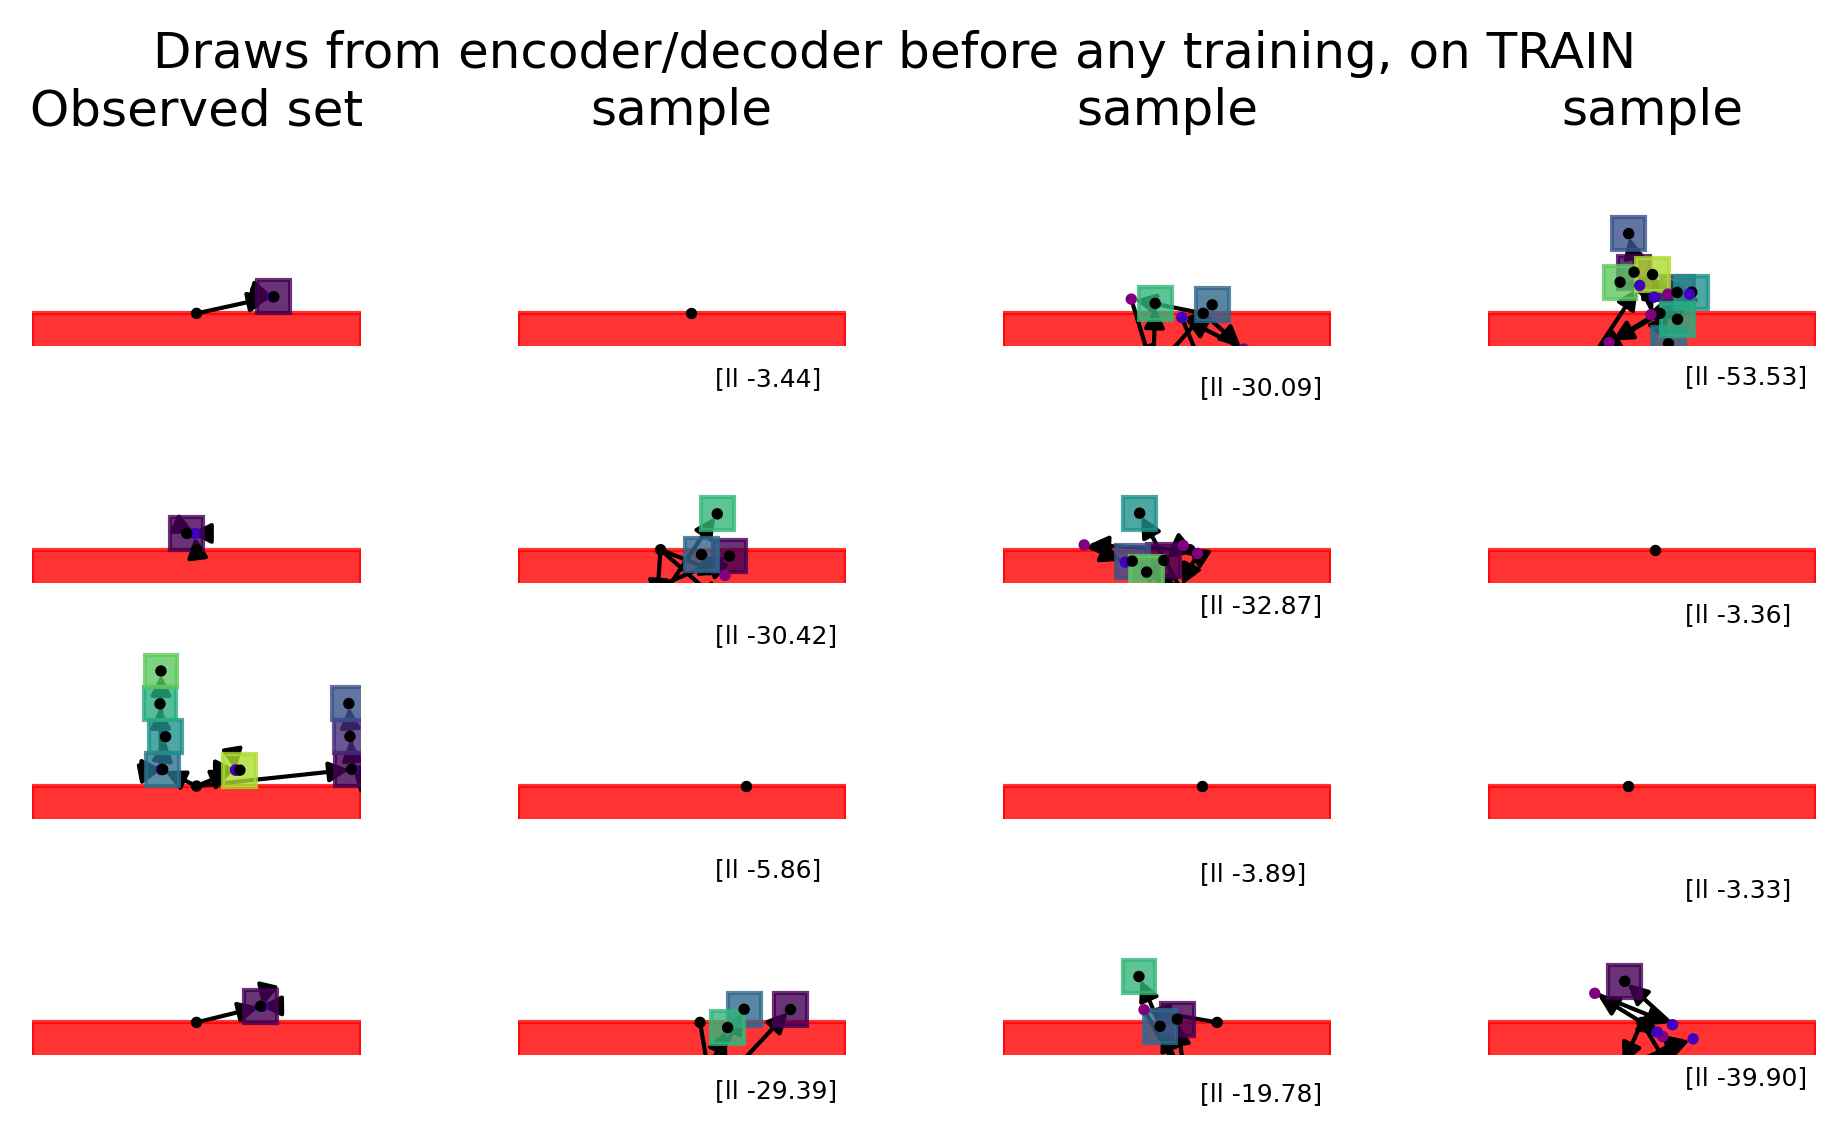

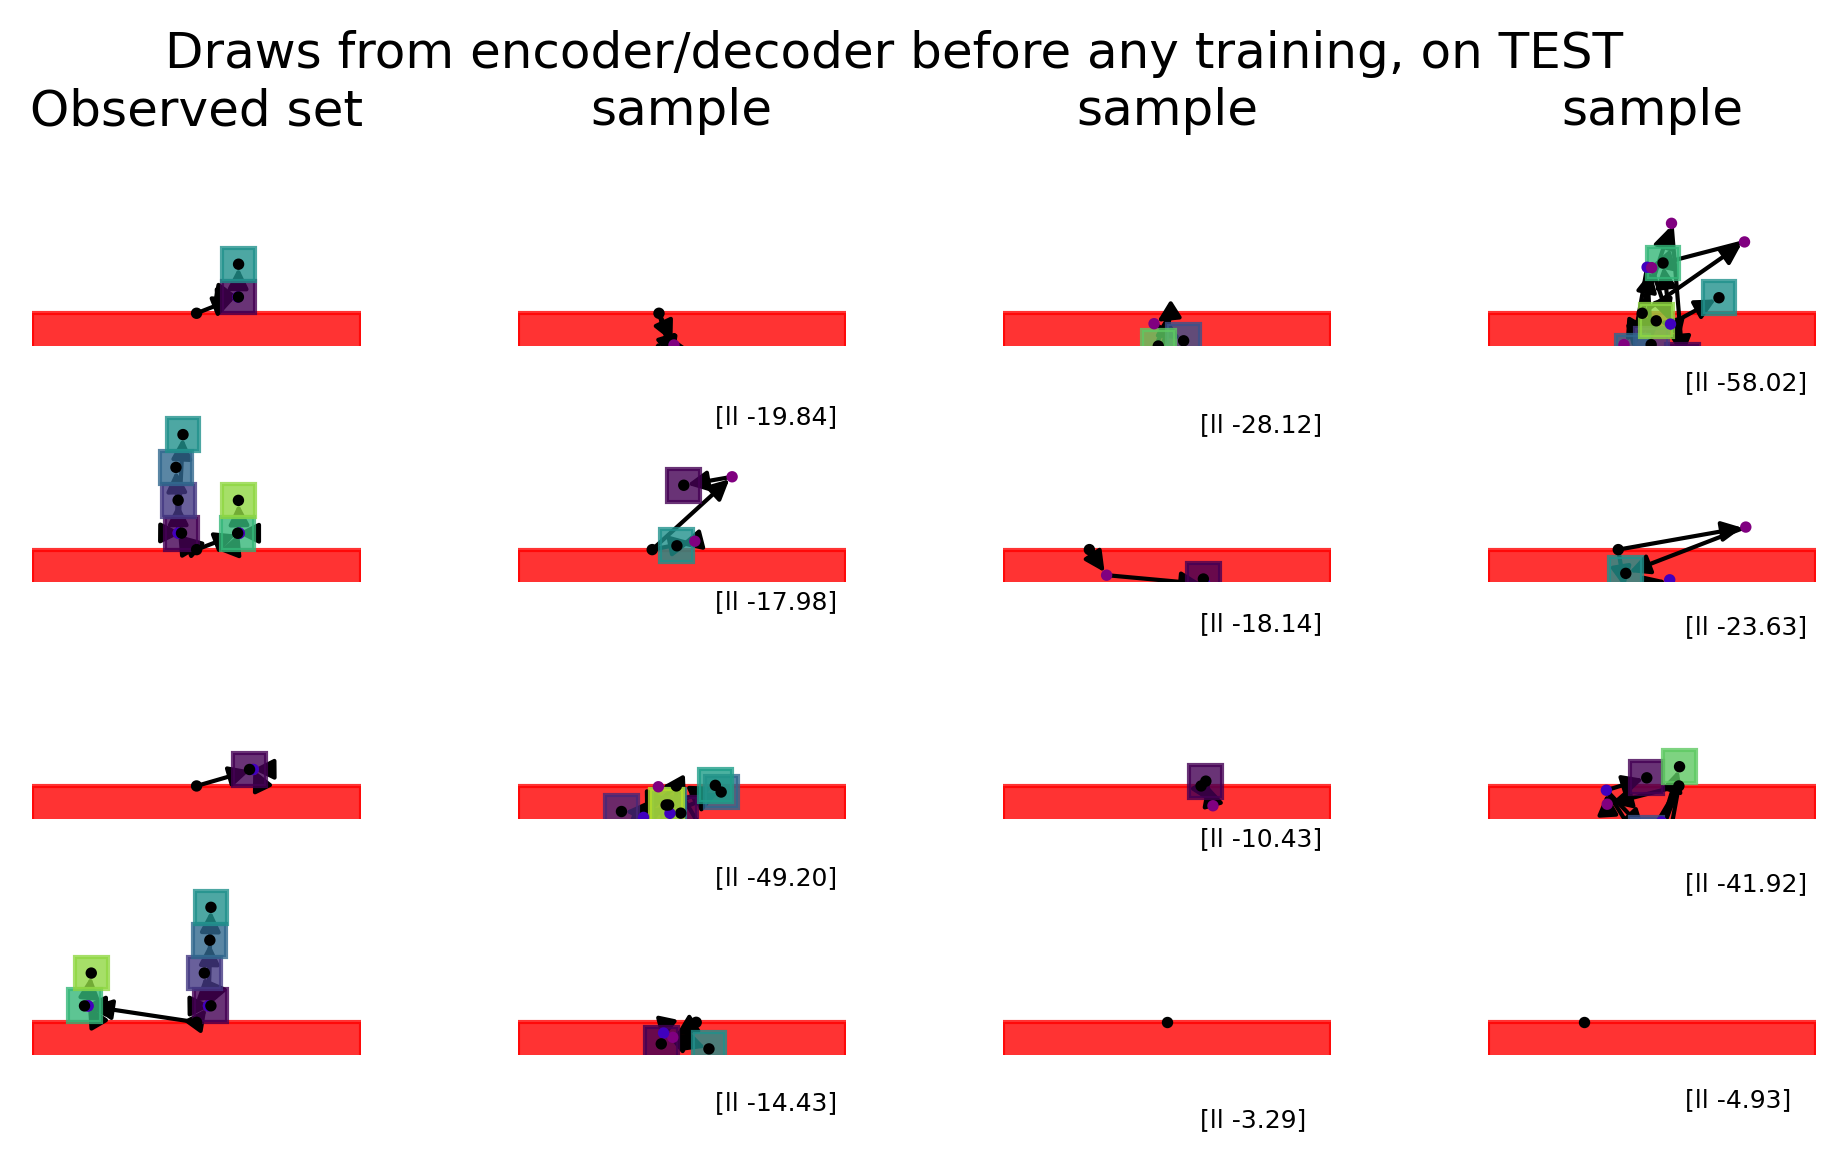

In [10]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(42)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder before any training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder before any training, on TEST")

0: 109.803543
100: -64.729660
200: -95.273712
300: -110.060059
400: -106.102417


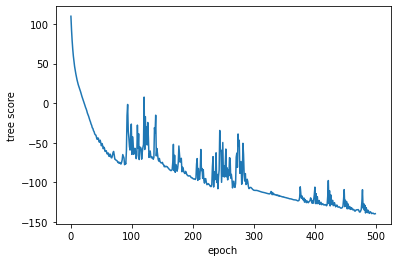

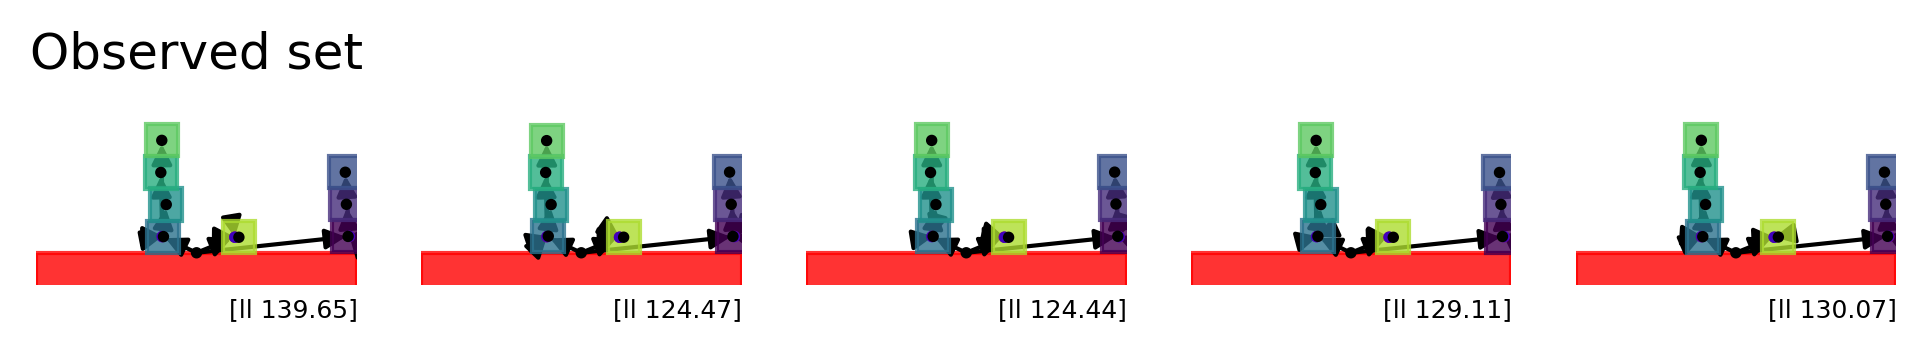

In [45]:
# Sanity-check grad descent: given a ground truth tree, can we
# recover the params of the auxiliary model that recover it?
full_tree = full_trees_for_training[2]
Nx = encoder.n_parameters
x = torch.normal(mean=torch.zeros(Nx), std=torch.ones(Nx)*0.1)
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=50, factor=0.5)
scores = []
for epoch in range(500):
    optimizer.zero_grad()
    score = -encoder.score_tree_with_grammar_vector(full_tree, x, detach=True)
    scores.append(score.detach().item())
    if epoch % 100 == 0:
        print("%d: %f" % (epoch, score))
    score.backward()
    optimizer.step()
    scheduler.step(score)
plt.plot(scores)
plt.xlabel("epoch")
plt.ylabel("tree score")
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 5
plt.subplot(1, N_width, 1)
draw_boxes(full_tree, fig=plt.gcf(), ax=plt.gca(), block=False)
plt.text(x=1., y=-2., s="[ll %0.2f]" % -score, fontsize=6)
plt.title("Observed set")
for k in range(N_width - 1):
    ax = plt.subplot(1, N_width, k + 2)
    plt.title("Sample %d" % k)
    sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
    draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
    plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

0:Mean objective 14.86, lr 0.001000
10:Mean objective 6.90, lr 0.001000
20:Mean objective 3.29, lr 0.001000
30:Mean objective 3.06, lr 0.001000
40:Mean objective 1.19, lr 0.001000
50:Mean objective 1.59, lr 0.001000
60:Mean objective 0.15, lr 0.000500
70:Mean objective 0.41, lr 0.000500
80:Mean objective 0.45, lr 0.000500
90:Mean objective 0.26, lr 0.000500
100:Mean objective 0.15, lr 0.000500
110:Mean objective 0.10, lr 0.000250
120:Mean objective 0.08, lr 0.000250
130:Mean objective 0.03, lr 0.000250
140:Mean objective 0.09, lr 0.000250
150:Mean objective 0.03, lr 0.000250
160:Mean objective 0.01, lr 0.000125
170:Mean objective 0.03, lr 0.000125
180:Mean objective 0.02, lr 0.000125
190:Mean objective 0.02, lr 0.000125
200:Mean objective 0.01, lr 0.000125
210:Mean objective 0.01, lr 0.000063
220:Mean objective 0.01, lr 0.000063
230:Mean objective 0.00, lr 0.000063
240:Mean objective 0.01, lr 0.000063
250:Mean objective 0.00, lr 0.000063
260:Mean objective 0.01, lr 0.000031
270:Mean ob

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


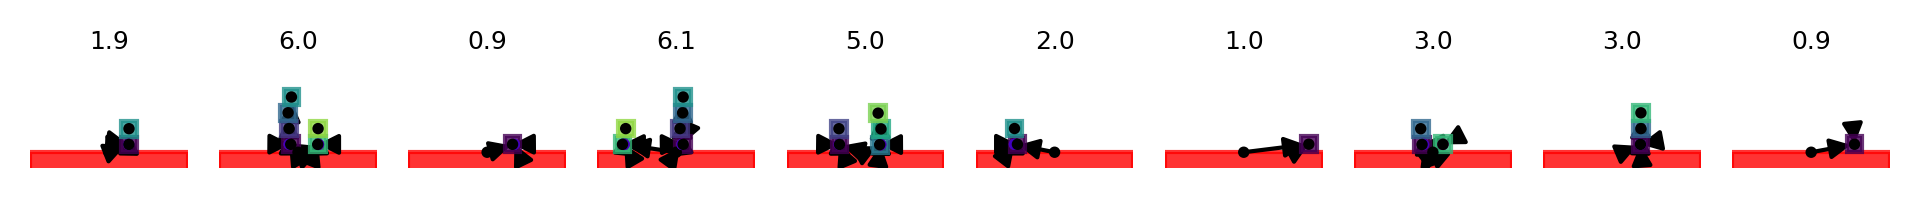

In [11]:
# Sanity check a simpler auxiliary task: can the encoder spit out x s.t. the first element of x
# is the number of objects?
# Training
N_EPOCHS = 500
N_ITERS_PER_EPOCH = 10
CLIP_VALUE = 1E3
torch.manual_seed(1234)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=50, factor=0.5)

total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        total_objective += torch.mean(torch.square(x[0] - len(observed_nodes)))
    
    mean_objective = total_objective / N_ITERS_PER_EPOCH
    total_objective_history.append(mean_objective)
    if (epoch % 10 == 0):
        print("%d:Mean objective %.2f, lr %f"
              % (epoch, mean_objective, optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (mean_objective).backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 10
plt.subplot(1, N_width, 1)
for k in range(N_width):
    ax = plt.subplot(1, N_width, k + 1)
    plt.title("Sample %d" % k)
    observed_nodes = observed_nodes_for_testing[k]
    x = encoder(observed_nodes)
    draw_boxes(full_trees_for_testing[k], fig=fig, ax=ax, block=False)
    plt.title("%0.1f" % x[0].item(), fontsize=6)

# Supervised [pre]training using full trees

This is for training the encoder to be in the neighborhood of being reasonable: given an observed tree, encode its observed nodes to get an inference grammar parameter set x, and then score the ground truth tree under that parameter set; backprob through x to increase the log-prob of the ground truth tree.

In [ ]:
# Training
N_EPOCHS = 5000
N_ITERS_PER_EPOCH = 100
CLIP_VALUE = 1E3
torch.manual_seed(1234)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=500, factor=0.5)

continuous_score_history = []
discrete_score_history = []
total_objective_history = []
score_history = []
all_gradients_history = {name: [] for name, _ in encoder.named_parameters()}
for epoch in range(N_EPOCHS):
    total_discrete_score = 0.
    total_continuous_score = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        
        full_tree = full_trees_for_training[iter_k]
        discrete_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=True,
            include_continuous=False
        )
        total_discrete_score += discrete_score
        continuous_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=False,
            include_continuous=True
        )
        total_continuous_score += continuous_score
    
    mean_discrete_score = total_discrete_score / N_ITERS_PER_EPOCH
    mean_continuous_score = total_continuous_score / N_ITERS_PER_EPOCH
    
    discrete_score_history.append(mean_discrete_score.detach())
    continuous_score_history.append(mean_continuous_score.detach())

    # Weight continuous factor to bring it to the same order of
    # magnitude as the discrete score.
    #avg_d = torch.tensor(discrete_score_history[-AVERAGE_WINDOW]).mean()
    #avg_c = torch.tensor(continuous_score_history[-AVERAGE_WINDOW]).mean()
    
    mean_objective = mean_discrete_score * 10. + mean_continuous_score
    total_objective_history.append(mean_objective)
    score_history.append(mean_objective)
    if (epoch % 1 == 0):
        print("%d:Mean objective %.2f, discrete %.2f, continuous %.2f, lr %f"
              % (epoch, mean_objective, mean_discrete_score, mean_continuous_score,
                 optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (-mean_objective).backward()
        # log gradients
        for name, param in encoder.named_parameters():
            if param.grad is None:
                all_gradients_history[name].append(torch.zeros(param.shape))
            else:
                all_gradients_history[name].append(deepcopy(param.grad.data))

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)

supervised_training_finish_time = time.time()

0:Mean objective -89.53, discrete -5.17, continuous -37.86, lr 0.001000
1:Mean objective -72.97, discrete -4.64, continuous -26.62, lr 0.001000
2:Mean objective -69.59, discrete -4.36, continuous -25.97, lr 0.001000
3:Mean objective -67.61, discrete -4.26, continuous -25.00, lr 0.001000
4:Mean objective -64.60, discrete -4.25, continuous -22.07, lr 0.001000
5:Mean objective -63.91, discrete -4.17, continuous -22.19, lr 0.001000
6:Mean objective -64.13, discrete -4.22, continuous -21.88, lr 0.001000
7:Mean objective -58.91, discrete -3.96, continuous -19.31, lr 0.001000
8:Mean objective -61.67, discrete -4.15, continuous -20.21, lr 0.001000
9:Mean objective -56.44, discrete -3.73, continuous -19.19, lr 0.001000
10:Mean objective -58.47, discrete -3.85, continuous -19.95, lr 0.001000
11:Mean objective -62.47, discrete -4.14, continuous -21.02, lr 0.001000
12:Mean objective -61.05, discrete -4.07, continuous -20.34, lr 0.001000
13:Mean objective -59.39, discrete -4.03, continuous -19.12, 

113:Mean objective -42.35, discrete -2.79, continuous -14.47, lr 0.001000
114:Mean objective -43.42, discrete -2.87, continuous -14.68, lr 0.001000
115:Mean objective -40.33, discrete -2.73, continuous -13.00, lr 0.001000
116:Mean objective -34.20, discrete -2.30, continuous -11.15, lr 0.001000
117:Mean objective -38.83, discrete -2.71, continuous -11.68, lr 0.001000
118:Mean objective -45.84, discrete -3.14, continuous -14.39, lr 0.001000
119:Mean objective -32.31, discrete -2.18, continuous -10.48, lr 0.001000
120:Mean objective -38.87, discrete -2.58, continuous -13.09, lr 0.001000
121:Mean objective -41.10, discrete -2.61, continuous -15.02, lr 0.001000
122:Mean objective -41.42, discrete -2.66, continuous -14.82, lr 0.001000
123:Mean objective -43.63, discrete -2.85, continuous -15.16, lr 0.001000
124:Mean objective -38.56, discrete -2.49, continuous -13.63, lr 0.001000
125:Mean objective -42.76, discrete -2.91, continuous -13.70, lr 0.001000
126:Mean objective -42.44, discrete -2

225:Mean objective -33.06, discrete -2.33, continuous -9.75, lr 0.001000
226:Mean objective -33.64, discrete -2.39, continuous -9.71, lr 0.001000
227:Mean objective -29.33, discrete -2.18, continuous -7.48, lr 0.001000
228:Mean objective -32.64, discrete -2.31, continuous -9.56, lr 0.001000
229:Mean objective -34.02, discrete -2.36, continuous -10.41, lr 0.001000
230:Mean objective -34.03, discrete -2.29, continuous -11.10, lr 0.001000
231:Mean objective -34.01, discrete -2.32, continuous -10.85, lr 0.001000
232:Mean objective -36.91, discrete -2.57, continuous -11.23, lr 0.001000
233:Mean objective -33.62, discrete -2.40, continuous -9.64, lr 0.001000
234:Mean objective -31.58, discrete -2.19, continuous -9.73, lr 0.001000
235:Mean objective -31.87, discrete -2.30, continuous -8.88, lr 0.001000
236:Mean objective -30.46, discrete -2.19, continuous -8.59, lr 0.001000
237:Mean objective -31.58, discrete -2.19, continuous -9.68, lr 0.001000
238:Mean objective -28.93, discrete -2.18, cont

338:Mean objective -34.09, discrete -2.47, continuous -9.38, lr 0.001000
339:Mean objective -40.45, discrete -2.77, continuous -12.76, lr 0.001000
340:Mean objective -28.47, discrete -2.11, continuous -7.41, lr 0.001000
341:Mean objective -29.19, discrete -2.11, continuous -8.06, lr 0.001000
342:Mean objective -26.01, discrete -2.00, continuous -6.05, lr 0.001000
343:Mean objective -32.08, discrete -2.36, continuous -8.51, lr 0.001000
344:Mean objective -28.36, discrete -2.06, continuous -7.77, lr 0.001000
345:Mean objective -30.62, discrete -2.29, continuous -7.73, lr 0.001000
346:Mean objective -27.44, discrete -2.08, continuous -6.60, lr 0.001000
347:Mean objective -30.63, discrete -2.35, continuous -7.10, lr 0.001000
348:Mean objective -30.69, discrete -2.34, continuous -7.26, lr 0.001000
349:Mean objective -20.52, discrete -1.64, continuous -4.15, lr 0.001000
350:Mean objective -29.09, discrete -2.05, continuous -8.59, lr 0.001000
351:Mean objective -24.80, discrete -1.89, continu

451:Mean objective -33.85, discrete -2.60, continuous -7.82, lr 0.001000
452:Mean objective -32.03, discrete -2.34, continuous -8.62, lr 0.001000
453:Mean objective -31.94, discrete -2.47, continuous -7.29, lr 0.001000
454:Mean objective -30.97, discrete -2.34, continuous -7.62, lr 0.001000
455:Mean objective -32.26, discrete -2.48, continuous -7.45, lr 0.001000
456:Mean objective -29.55, discrete -2.21, continuous -7.44, lr 0.001000
457:Mean objective -29.60, discrete -2.16, continuous -8.05, lr 0.001000
458:Mean objective -33.09, discrete -2.39, continuous -9.15, lr 0.001000
459:Mean objective -31.39, discrete -2.36, continuous -7.80, lr 0.001000
460:Mean objective -34.41, discrete -2.50, continuous -9.43, lr 0.001000
461:Mean objective -30.14, discrete -2.30, continuous -7.13, lr 0.001000
462:Mean objective -35.20, discrete -2.59, continuous -9.26, lr 0.001000
463:Mean objective -33.00, discrete -2.51, continuous -7.90, lr 0.001000
464:Mean objective -32.43, discrete -2.47, continuo

564:Mean objective -27.10, discrete -2.06, continuous -6.50, lr 0.001000
565:Mean objective -26.51, discrete -2.06, continuous -5.94, lr 0.001000
566:Mean objective -26.72, discrete -2.03, continuous -6.46, lr 0.001000
567:Mean objective -33.92, discrete -2.52, continuous -8.74, lr 0.001000
568:Mean objective -26.65, discrete -1.99, continuous -6.75, lr 0.001000
569:Mean objective -30.18, discrete -2.27, continuous -7.51, lr 0.001000
570:Mean objective -29.83, discrete -2.16, continuous -8.26, lr 0.001000
571:Mean objective -27.15, discrete -1.94, continuous -7.73, lr 0.001000
572:Mean objective -32.33, discrete -2.05, continuous -11.83, lr 0.001000
573:Mean objective -30.97, discrete -2.24, continuous -8.56, lr 0.001000
574:Mean objective -33.79, discrete -2.48, continuous -9.00, lr 0.001000
575:Mean objective -38.71, discrete -2.67, continuous -12.01, lr 0.001000
576:Mean objective -35.64, discrete -2.60, continuous -9.65, lr 0.001000
577:Mean objective -35.52, discrete -2.58, contin

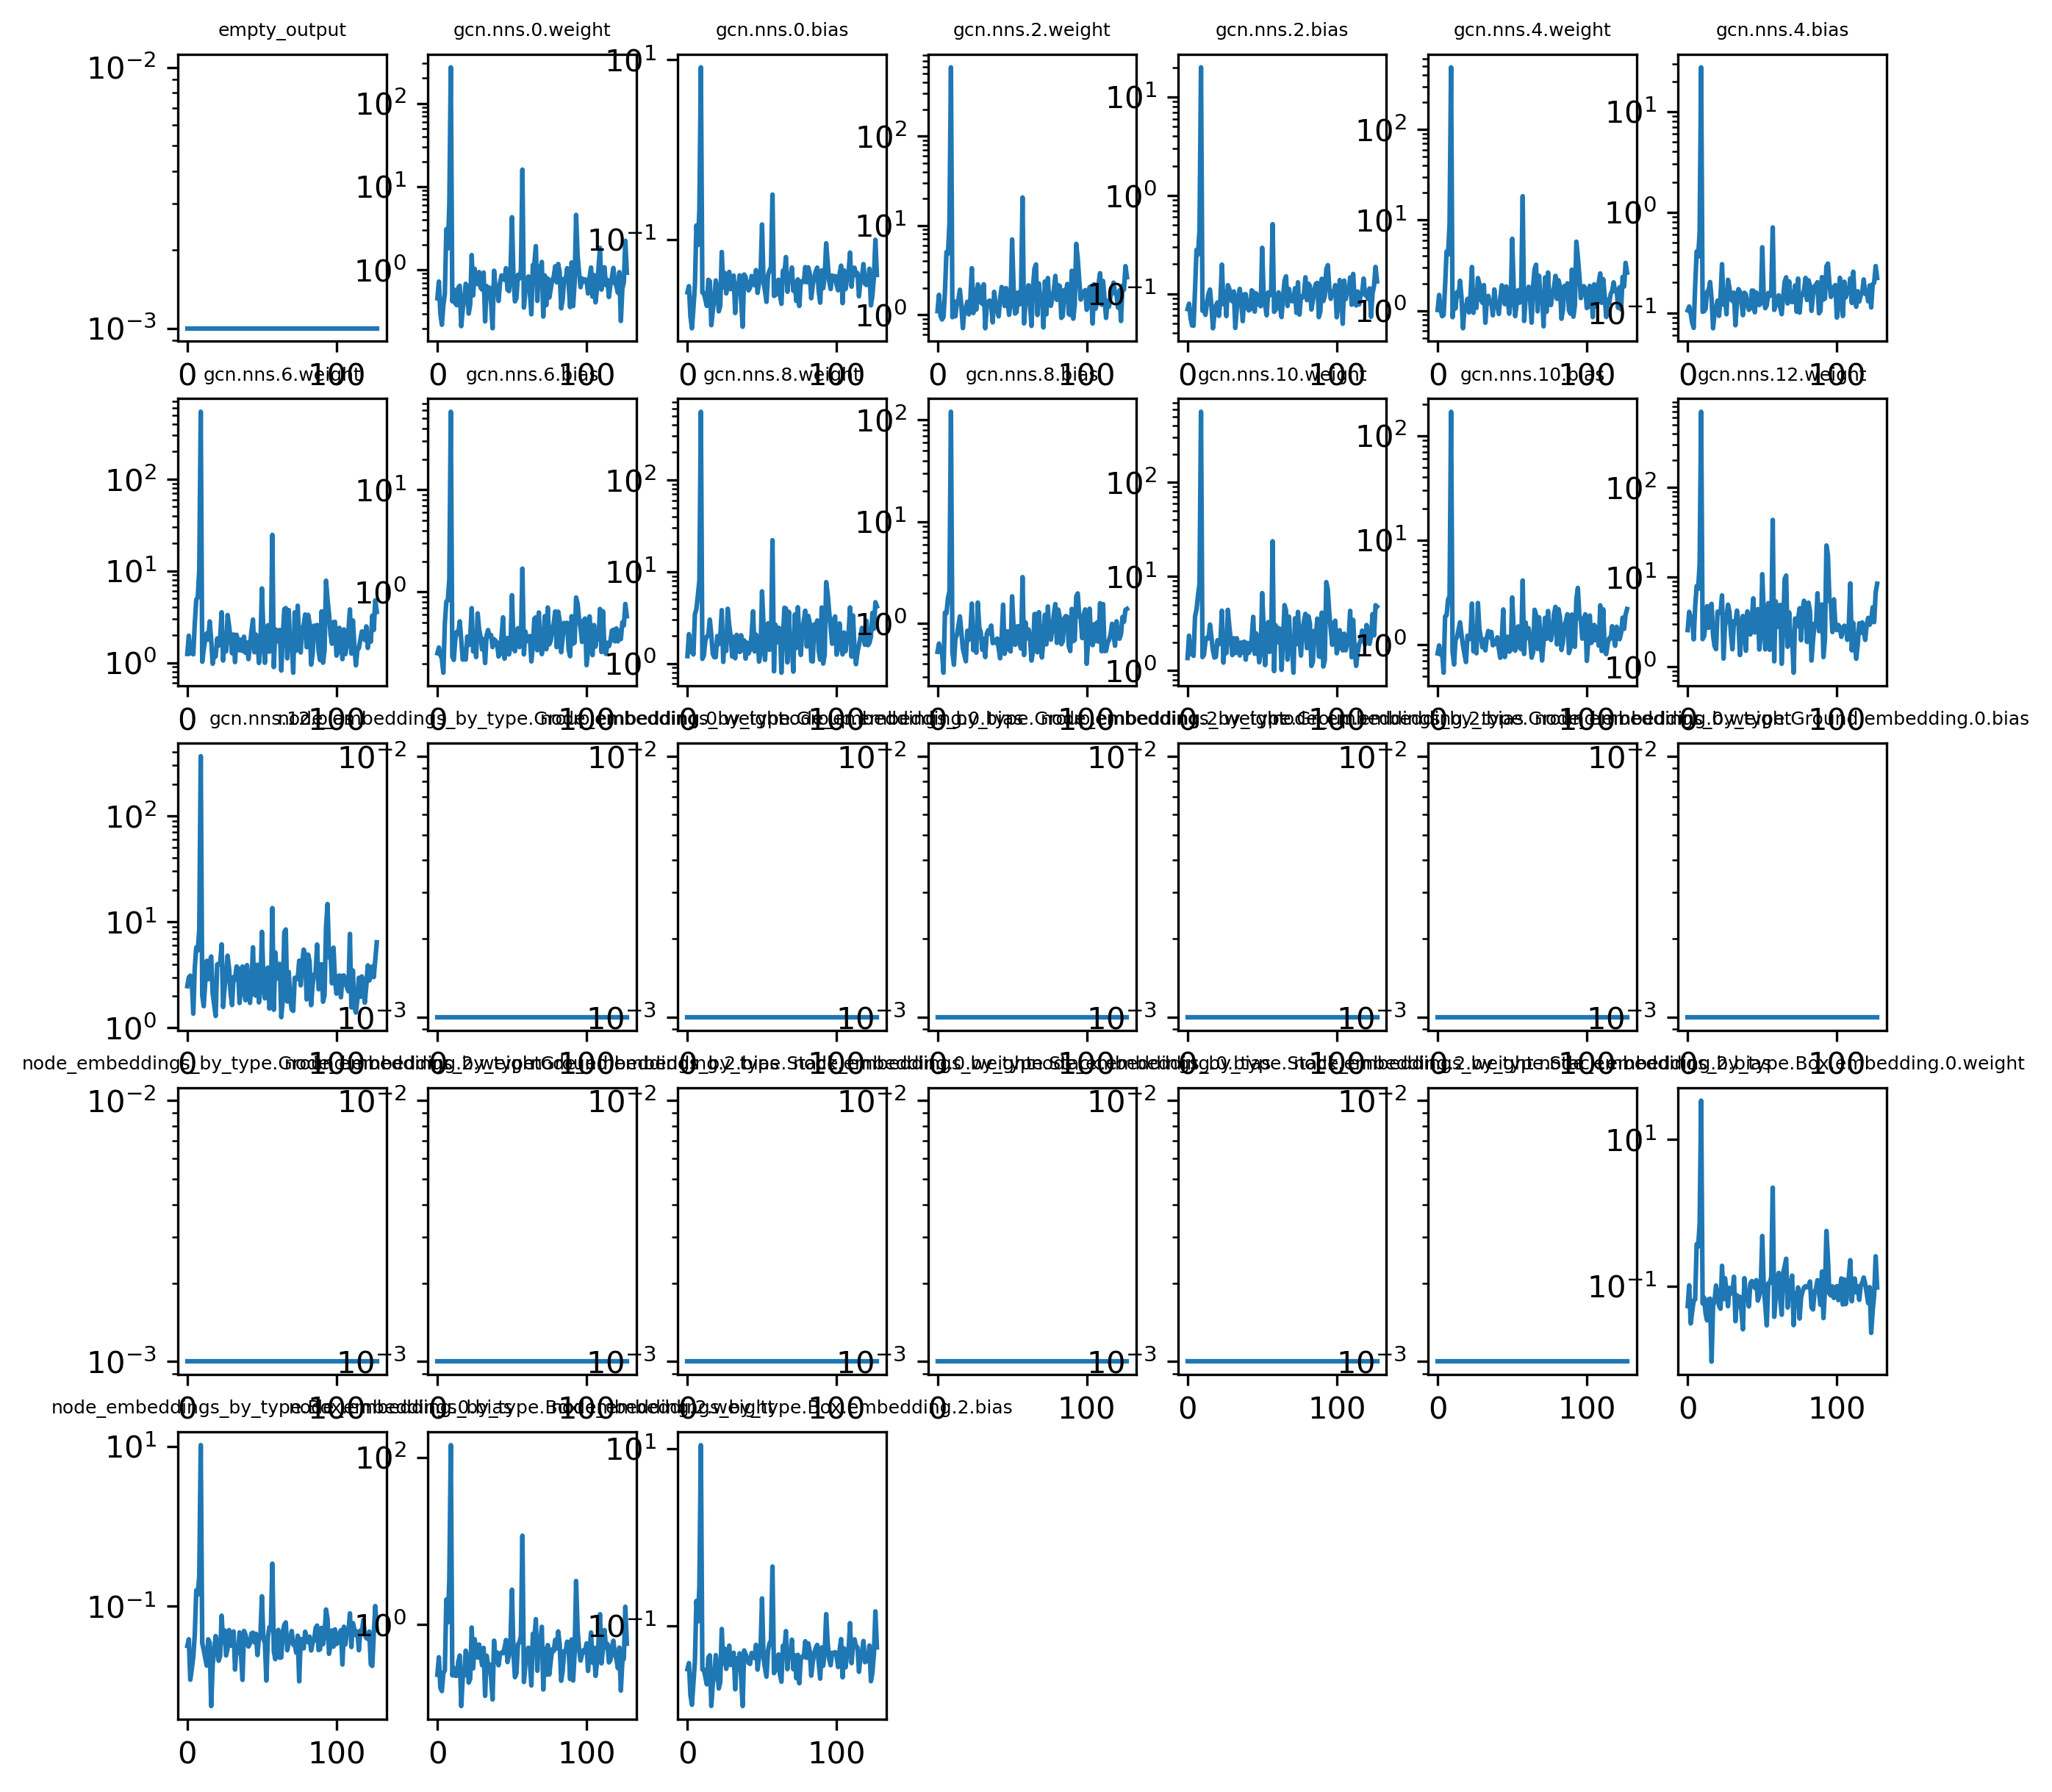

In [57]:
# Draw gradient norm history per param
plt.figure(dpi=300).set_size_inches(10, 10)
n_params = len(all_gradients_history.keys())
for k, (name, history) in enumerate(all_gradients_history.items()):
    ax = plt.subplot(5, n_params // 5 + 1, k+1)
    history = torch.stack(history)
    history = np.linalg.norm(history.reshape(history.shape[0], -1).numpy(), axis=1) + 1E-3
    x = range(history.shape[0])
    ax.plot(x, history)
    plt.yscale("log")
    #ax.fill_between(x, (means-std), (means+std), color='b', alpha=.1)
    plt.title(name, fontsize=6)

(-100.0, 10.0)

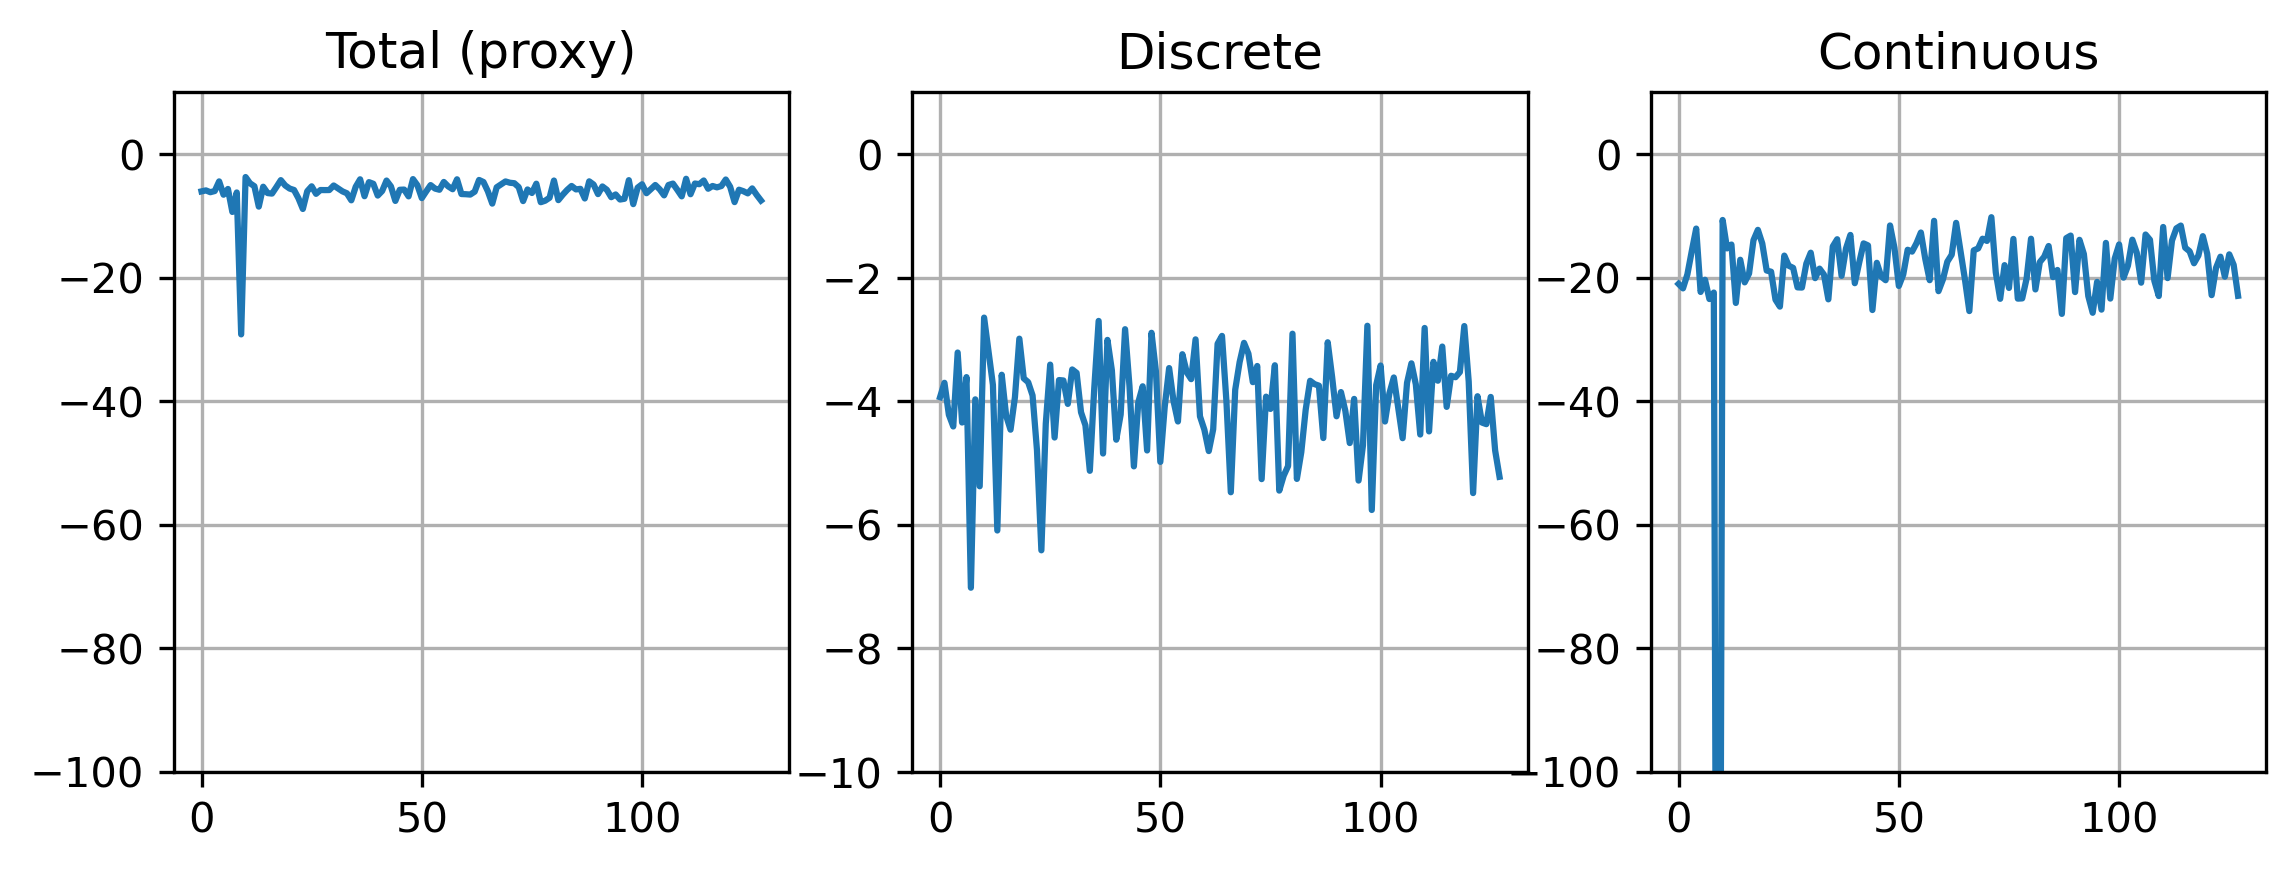

In [56]:
plt.figure(dpi=300).set_size_inches(9, 3)
plt.subplot(1, 3, 1)
plt.title("Total (proxy)")
plt.plot(total_objective_history)
plt.ylim(-100, 10.)
plt.grid(True)
plt.subplot(1, 3, 2)
plt.title("Discrete")
plt.plot(discrete_score_history)
plt.grid(True)
plt.ylim(-10, 1.)
plt.subplot(1, 3, 3)
plt.title("Continuous")
plt.plot(continuous_score_history)
plt.grid(True)
plt.ylim(-100, 10.)

Entering example  0


/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Entering example  1
Entering example  2
Entering example  3
Entering example  0
Entering example  1
Entering example  2
Entering example  3


Text(0.5, 0.98, 'Draws from encoder/decoder after supervised training, on TEST')

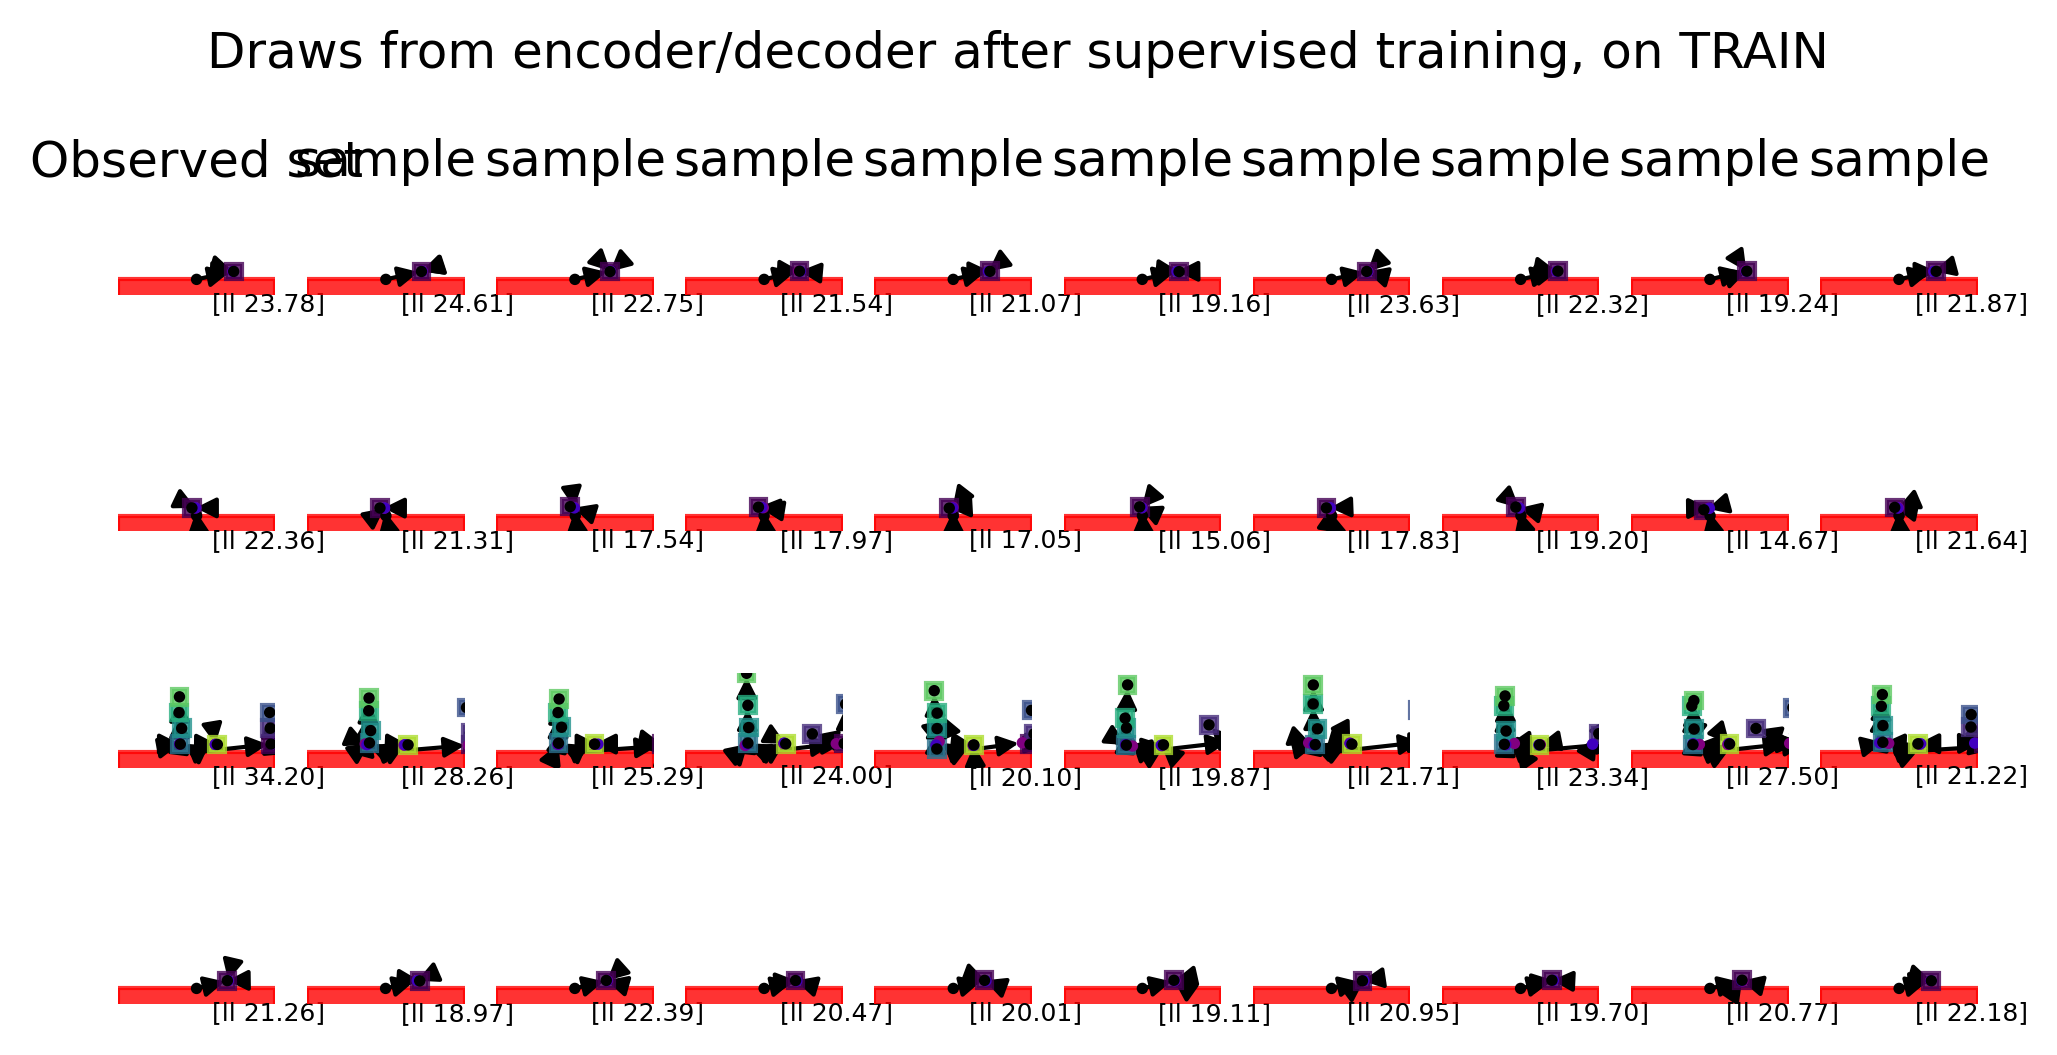

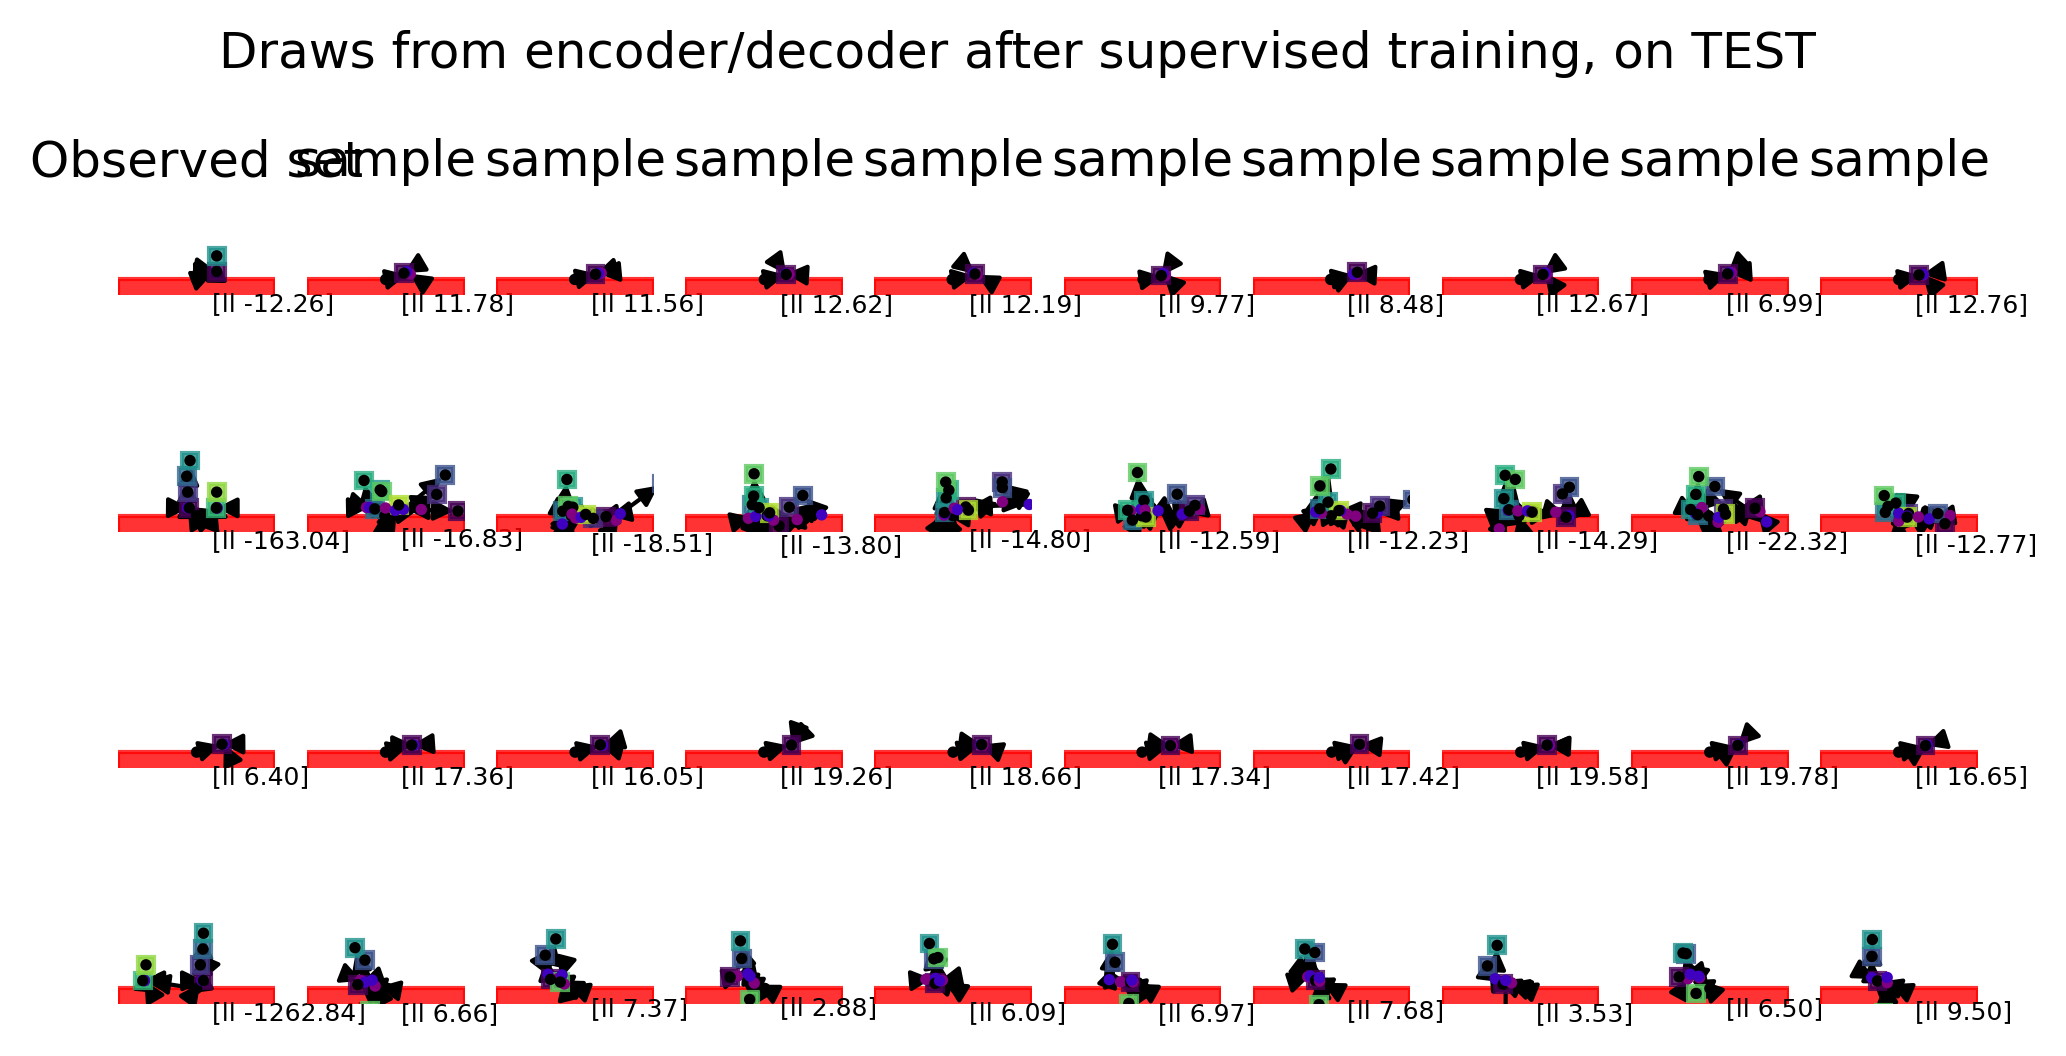

In [52]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 10
    N_height = 4
    torch.random.manual_seed(41)
    
    for i in range(N_height):
        print("Entering example ", i)
        plt.subplot(N_height, N_width, i*N_width + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        
        # Score the test tree under its encoded vector
        density = encoder.score_tree_with_grammar_vector(full_trees[i], x, include_continuous=True)
        plt.text(x=1., y=-2., s="[ll %0.2f]" % density, fontsize=6)
        
        for j in range(1, N_width):
            k = i*N_width + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, _, _ = encoder.sample_tree_from_grammar_vector(x)
            proposal_density = encoder.score_tree_with_grammar_vector(sampled_tree, x, include_continuous=True)
            #box_k = 0
            #for node in sampled_tree.nodes:
            #    if isinstance(node, Box):
            #        node.xy = torch.tensor([0., box_k])
            #        box_k += 1
            #    else:
            #        node.xy = torch.zeros(2)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after supervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after supervised training, on TEST")

In [ ]:
# Save output
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime())
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_supervised_%0.04f.torch" % (
    total_objective_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)

# Autoencoder Loss Training via Reinforce

Encoding is deterministic, but decoding involves drawing samples of trees from that distribution. I'll notate that whole parameterized enc-decode sampling as drawing $t \sim q_\theta(t^*)$.

To first see if things work, I'd like to directly optimize a loss function $f$ that roughly enforces observed node similarity while being close to the proposal density prior and original grammar prior  $max_\theta E_{t \sim q_\theta(t^*)}\Big[ f(t, t^*) \Big] + log p(\theta)$, for $f(t, t^*) = L(t, t^*) + p(t)$.

So we've unfortunately to use REINFORCE since the decoder is a complex sampling procedure, so our gradient estimate is $E_{t \sim q_\theta(t^*)}\Big[ (f(t, t^*) \nabla_\theta \log q_\theta(t^*) \Big] + log p(\theta) $. (Since I'm operating in pytorch, I'll build a surrogate objective that has that gradient.)


In [ ]:
# Training
N_EPOCHS = 450
N_ITERS_PER_EPOCH = 10
N_SAMPLES_PER_ENCODING = 5
MIN_LL_SATURATION = -10000

torch.manual_seed(43)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,300], gamma=0.33)
mean_sampled_f_history = []
mean_sampled_score_history = []
total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    total_sampled_f = 0.
    total_sampled_score = 0.
    total_num_samples = 0
    optimizer.zero_grad()

    if len(mean_sampled_f_history) == 0:
        decaying_avg_baseline = 0.
    elif len(mean_sampled_f_history) < 10:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history))
    else:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history[-10:]))

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        # Calculate contribution of encoding prior (very weak, just keeps values from
        # blowing up.)
        #x_prior_ll = dist.Normal(0., 10.).log_prob(x).sum()
        #total_objective += x_prior_ll * N_SAMPLES_PER_ENCODING
        for sample_k in range(N_SAMPLES_PER_ENCODING):
            sampled_tree, proposal_density_ll, nonreparam_density_ll = encoder.sample_tree_from_grammar_vector(x)
            candidate_nodes = [n for n in sampled_tree.nodes if isinstance(n, TerminalNode)]
            
            # Calculate observation matching score.
            est_ll = (estimate_observation_likelihood(candidate_nodes, observed_nodes, 0.1, detach_second=True) +
                      estimate_observation_likelihood(observed_nodes, candidate_nodes, 0.1, detach_first=True)).sum()
            est_ll = torch.clip(est_ll, min=MIN_LL_SATURATION)
            
            # Calculate grammar prior score.
            grammar_ll = grammar.score(sampled_tree)
            
            # Total value under expectation for evaluation policy gradient.
            total_f = est_ll# + grammar_ll
            
            # Diagnostics
            total_sampled_score += est_ll
            total_sampled_f += total_f
            
            # Surrogate objective for REINFORCE
            total_objective += (total_f.detach() - decaying_avg_baseline) * nonreparam_density_ll + total_f
            total_num_samples += 1

    mean_objective = total_objective / total_num_samples
    mean_sampled_f = total_sampled_f / total_num_samples
    mean_sampled_score = total_sampled_score / total_num_samples
    mean_sampled_f_history.append(mean_sampled_f)
    total_objective_history.append(mean_objective)

    print("%d: Mean sampled loss %.2f, f %.2f, Mean objective %.2f"
          % (epoch, mean_sampled_score, mean_sampled_f, mean_objective))
    
    if torch.isfinite(mean_objective):
        # Parameter values get gradients calculated but not used;
        # need to retain them to keep pytorch from complaining.
        (-mean_objective).backward(retain_graph=True)
        optimizer.step()
        scheduler.step()

unsupervised_training_finish_time = time.time()

# Test gradient
#from torchviz import make_dot
#make_dot(mean_sampled_f, params=dict(encoder.named_parameters()))

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(np.array(mean_sampled_f_history) - max(mean_sampled_f_history).item())
plt.title("Mean sampled f, relative to max")      
plt.yscale('symlog')
plt.subplot(1, 2, 2)
plt.plot(np.array(mean_sampled_f_history))
plt.title("Total objective")

In [ ]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TEST")


In [ ]:
# Save weights
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime(supervised_training_finish_time))
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_unsupervised_%0.04f.torch" % (
    mean_sampled_f_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)